In [5]:
### import
import torch
from torch import nn
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import copy
import pickle

from SRCNN_classes import SRCNN, transform_class, PSNR
from datasets import TrainDataset, EvalDataset


In [6]:
### device setting
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
### hyperparameters setting
num_epochs = 4 # 1000
batch_size = 16

kernel_size = [9,3,5] # need to handle

In [8]:
### Dataset setting
train_dataset_file = 'dataset/91-image_x3.h5'
eval_dataset_file = 'dataset/Set5_x3.h5'

tranform_train = transform_class(kernel_size=kernel_size)
transform_eval = transform_class(kernel_size=kernel_size)

train_dataset = TrainDataset(root=train_dataset_file, target_transform=tranform_train.crop(33,33))
eval_dataset = EvalDataset(root=eval_dataset_file, target_transform=transform_eval)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset,
                                          batch_size=1,
                                          shuffle=False)

In [10]:
### Checking data
print('number of train data: (about)', batch_size*len(train_loader))
print('number of eval data: ', 1*len(eval_loader))

for X_train, y_train in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type()) # input
    print('y_train:', y_train.size(), 'type:', y_train.type()) # ground truth high-resolution image
    break

for X_eval, y_eval in eval_loader:
    print('X_eval:', X_eval.size(), 'type:', X_eval.type()) # input
    print('y_eval:', y_eval.size(), 'type:', y_eval.type()) # ground truth high-resolution image

number of train data: (about) 21888
number of eval data:  5
X_train: torch.Size([16, 1, 33, 33]) type: torch.FloatTensor
y_train: torch.Size([16, 1, 19, 19]) type: torch.FloatTensor
X_eval: torch.Size([1, 1, 510, 510]) type: torch.FloatTensor
y_eval: torch.Size([1, 1, 496, 496]) type: torch.FloatTensor
X_eval: torch.Size([1, 1, 288, 288]) type: torch.FloatTensor
y_eval: torch.Size([1, 1, 274, 274]) type: torch.FloatTensor
X_eval: torch.Size([1, 1, 255, 255]) type: torch.FloatTensor
y_eval: torch.Size([1, 1, 241, 241]) type: torch.FloatTensor
X_eval: torch.Size([1, 1, 279, 279]) type: torch.FloatTensor
y_eval: torch.Size([1, 1, 265, 265]) type: torch.FloatTensor
X_eval: torch.Size([1, 1, 342, 228]) type: torch.FloatTensor
y_eval: torch.Size([1, 1, 328, 214]) type: torch.FloatTensor


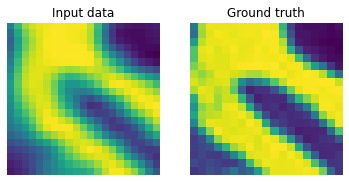

In [11]:
### Show image
fig = plt.figure()
rows = 1
cols = 2

crop_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(21)
])

ax1 = fig.add_subplot(rows, cols, 1)
img1 = crop_transform(X_train[1][0])
ax1.imshow(img1)
ax1.set_title('Input data')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(y_train[1][0])
ax2.set_title('Ground truth')
ax2.axis("off")

plt.show()

In [12]:
### Configure Optimizer, Objective function
model = SRCNN(kernel_size=kernel_size).to(device)
optimizer = torch.optim.SGD([
                                {'params': model.layer1.parameters()},
                                {'params': model.layer2.parameters()},
                                {'params': model.layer3.parameters(), 'lr': 1e-5}
                            ], lr=1e-4, momentum=0.9)
criterion = nn.MSELoss()

print(model, '\n')
print('Number of parameters: {}'.format(sum(p.numel() for p in model.parameters())))
for p in model.parameters():
    print(p.size())

SRCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1))
) 

Number of parameters: 24513
torch.Size([64, 1, 9, 9])
torch.Size([64])
torch.Size([32, 64, 3, 3])
torch.Size([32])
torch.Size([1, 32, 5, 5])
torch.Size([1])


In [13]:
### model training 
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)

        # Forward pass
        output = model(image)
        loss = criterion(output, label)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printing the result at the specific interval
        if batch_idx % log_interval == 0: # log_interval = 100
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx, len(train_loader), 100. * batch_idx / len(train_loader),
                loss.item()))

In [14]:
### model evaluation
def evaluate(model, eval_loader):
    model.eval()
    
    eval_loss = 0
    correct = 0

    psnr_list = []

    with torch.no_grad():
        for image, label in eval_loader:
            image = image.to(device)
            label = label.to(device)
            
            output = model(image)

            # psnr caculate
            psnr_list.append(PSNR(output,label))
            eval_loss += criterion(output, label).item()

    eval_loss /= len(eval_loader.dataset)
    eval_psnr = sum(psnr_list)/len(psnr_list)
    return eval_loss, eval_psnr

In [17]:
### Training and Evaluation
psnr_epoch = []
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, log_interval = 100)
    eval_loss, eval_psnr = evaluate(model, eval_loader)
    print("\n[EPOCH: {}/{}], \tEvaluate Loss: {:.4f}, \tEvaluate PSNR: {:.2f} % \n".format(
        epoch, num_epochs, eval_loss, eval_psnr))
    psnr_epoch.append(eval_psnr)

pickle.dump(psnr_epoch, open('./results/psnr_list.pickle','wb'))

model_weight = copy.deepcopy(model.state_dict())
torch.save(model_weight, './results/model_weight.pth')


Train Epoch: 1 [0/1368 (0%)]	Train Loss: 0.003898
Train Epoch: 1 [100/1368 (7%)]	Train Loss: 0.006416
Train Epoch: 1 [200/1368 (15%)]	Train Loss: 0.003439
Train Epoch: 1 [300/1368 (22%)]	Train Loss: 0.005138
Train Epoch: 1 [400/1368 (29%)]	Train Loss: 0.004284
Train Epoch: 1 [500/1368 (37%)]	Train Loss: 0.005160
Train Epoch: 1 [600/1368 (44%)]	Train Loss: 0.004120
Train Epoch: 1 [700/1368 (51%)]	Train Loss: 0.005202
Train Epoch: 1 [800/1368 (58%)]	Train Loss: 0.004686
Train Epoch: 1 [900/1368 (66%)]	Train Loss: 0.004645
Train Epoch: 1 [1000/1368 (73%)]	Train Loss: 0.003754
Train Epoch: 1 [1100/1368 (80%)]	Train Loss: 0.004066
Train Epoch: 1 [1200/1368 (88%)]	Train Loss: 0.005384
Train Epoch: 1 [1300/1368 (95%)]	Train Loss: 0.004497

[EPOCH: 1/4], 	Evaluate Loss: 0.0046, 	Evaluate PSNR: 25.11 % 

Train Epoch: 2 [0/1368 (0%)]	Train Loss: 0.007826
Train Epoch: 2 [100/1368 (7%)]	Train Loss: 0.004110
Train Epoch: 2 [200/1368 (15%)]	Train Loss: 0.003371
Train Epoch: 2 [300/1368 (22%)]	Train 